# 🧠 Détection de Tumeurs Cérébrales par YOLOv8

Dans ce projet, nous mettons en œuvre un modèle de deep learning de dernière génération pour détecter des tumeurs cérébrales à partir d'IRM.  
Nous utilisons l'architecture **YOLOv8**, réputée pour son efficacité en détection d'objets.  
Le but est de proposer un outil rapide et précis qui pourrait à terme assister les professionnels de santé dans le diagnostic.

---

## 📚 1. Installation des dépendances

Nous installons les bibliothèques nécessaires et nous vérifions que nous utilisons la dernière version de YOLOv8 proposée par **Ultralytics**.


In [23]:
# ===============================
# Installation des dépendances
# ===============================

# Installation de YOLOv8 depuis Ultralytics
!pip install ultralytics --upgrade --quiet
!pip install albumentations --quiet


# Vérification de la version de YOLO installée
import ultralytics
print(f"Ultralytics YOLOv8 version : {ultralytics.__version__}")


Ultralytics YOLOv8 version : 8.3.120


---

## 2. Importation des bibliothèques utiles

Nous importons les bibliothèques essentielles :
- **CV2** pour le traitement d'image.
- **Matplotlib** pour la visualisation.
- **YOLOv8** pour la détection de tumeurs.


In [24]:
# ======================================
# 📦 Importation des bibliothèques utiles
# ======================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import display, Image


---

## 📂 3. Chargement et préparation des données

Nous utilisons un dataset organisé en trois sous-ensembles : `train`, `val`, `test`.  
Chaque image est annotée avec une étiquette précisant la présence ou non de tumeur et parfois son type (gliome, méningiome, etc.).

Le fichier `data.yaml` configure l'architecture de notre dataset pour l'entraînement YOLO.


In [29]:
import zipfile
import os
from zipfile import BadZipFile # Import BadZipFile explicitly

# Supposons que tu as chargé 'brain_tumor_dataset.zip' dans ton espace /content
zip_path = "/content/brain_tumor_dataset.zip"
extract_path = "/content/brain_tumor_dataset"

# Vérification de l'existence du fichier zip
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Le fichier {zip_path} n'a pas été trouvé. Veuillez vous assurer qu'il a été téléchargé correctement.")

# Vérification if the file size is nonzero
if os.path.getsize(zip_path) == 0:
    raise BadZipFile(f"Le fichier {zip_path} est vide. Veuillez re-télécharger le fichier.")

# Vérification si le fichier est bien un fichier zip
# (Ajout de cette vérification)
if not zipfile.is_zipfile(zip_path):
    # Run file command to inspect the file
    !file "$zip_path"
    raise BadZipFile(f"Le fichier {zip_path} n'est pas un fichier zip valide. Veuillez vérifier le fichier.")

# Décompression
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset décompressé avec succès.")

✅ Dataset décompressé avec succès.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


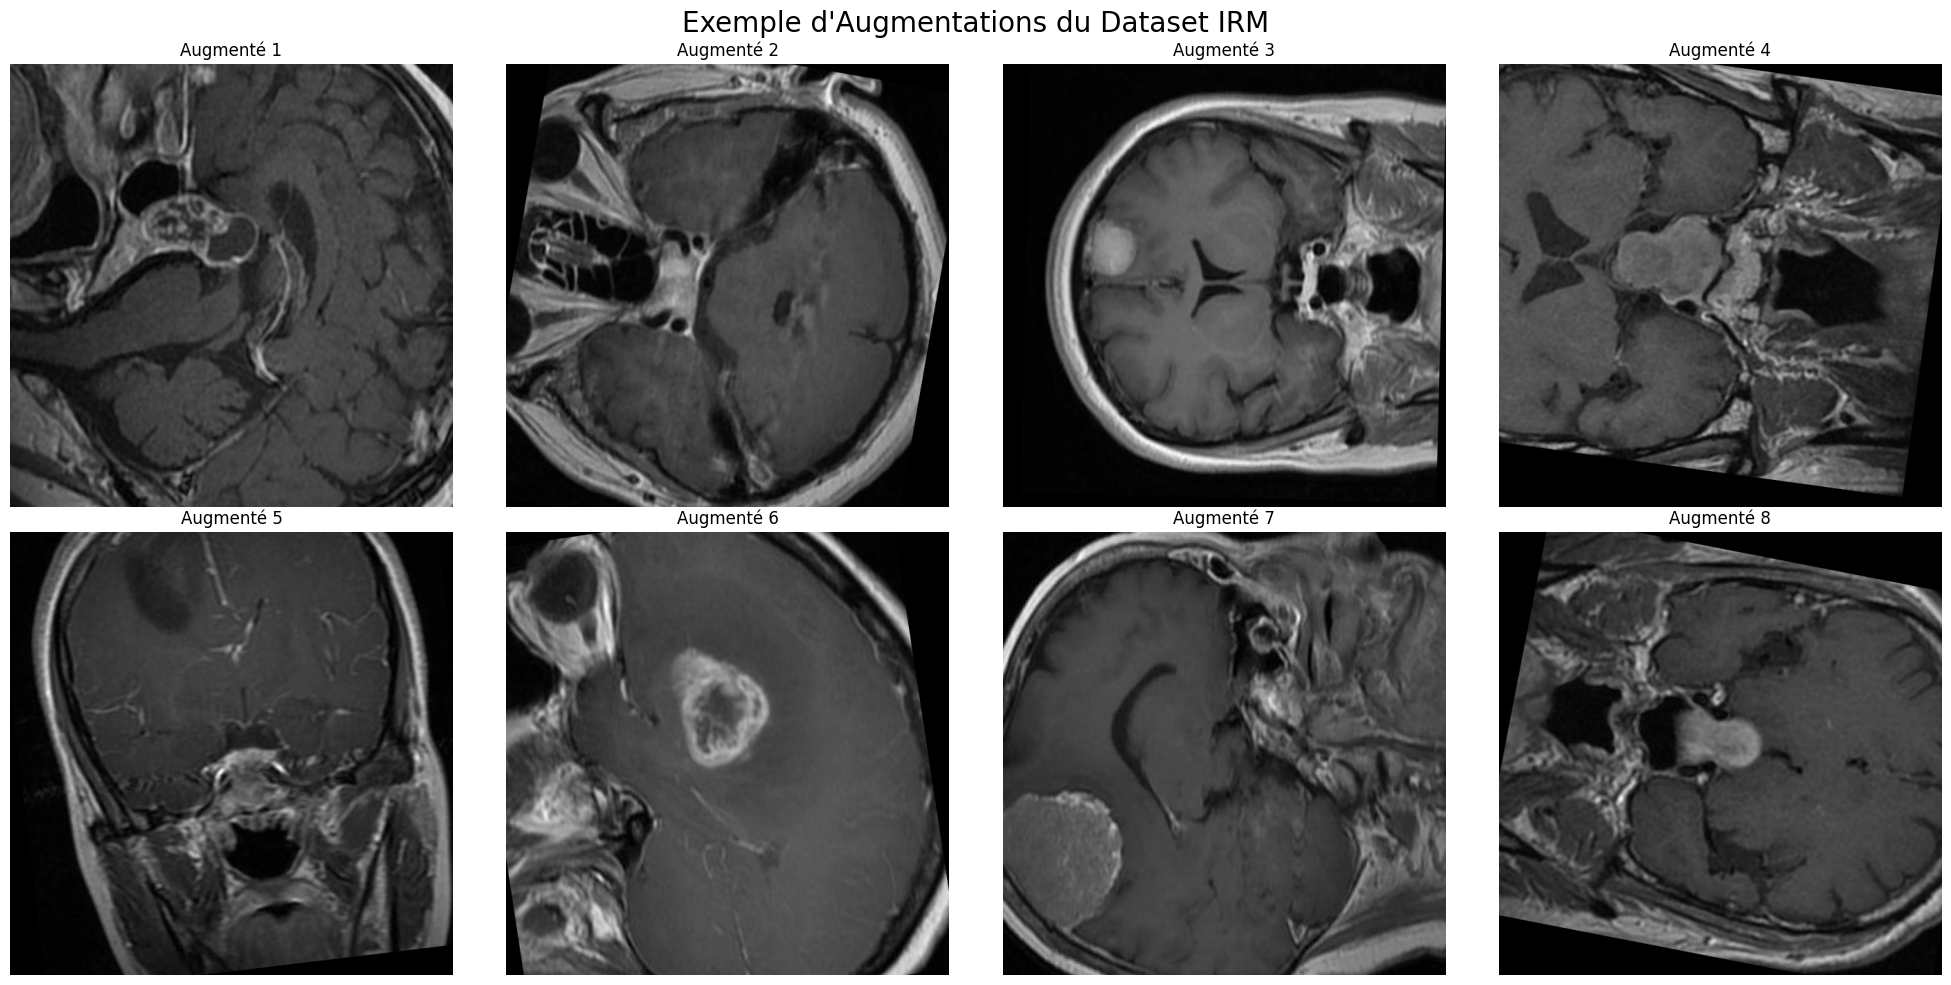

In [30]:
# ============================================
# 🧬 Data Augmentation sur le dataset - Visualisation
# ============================================

import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
import cv2
import random
import os

# Définir une transformation réaliste (pro santé)
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ElasticTransform(p=0.2),
    A.GaussNoise(p=0.2),
])

# Define the path to your test images
# Assuming your dataset is extracted to /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8
dataset_path = "/content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8"
test_images_path = os.path.join(dataset_path, "test", "images") # Define test_images_path here

# Charger des images du dataset test
num_samples = 8
sample_images = random.sample(os.listdir(test_images_path), num_samples)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Exemple d\'Augmentations du Dataset IRM', fontsize=20)

for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(test_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    augmented = transform(image=img)['image']

    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(augmented)
    axes[row, col].set_title(f"Augmenté {idx+1}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

In [31]:
# ===========================
# Définition des chemins
# ===========================

# Nouveau chemin après décompression
dataset_path = "/content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8"
yaml_path = os.path.join(dataset_path, "data.yaml")

# Vérification
assert os.path.exists(yaml_path), "Erreur : Le fichier YAML de configuration n'existe pas."
print(f"Fichier YAML trouvé : {yaml_path}")


Fichier YAML trouvé : /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/data.yaml


---

## 4. Chargement du modèle pré-entraîné

Nous utilisons une version compacte de YOLOv8 (`yolov8n.pt`) pour un compromis optimal entre performance et vitesse.  
Le modèle sera ensuite affiné (fine-tuned) sur notre dataset médical spécifique.


In [32]:
# ====================================
# 🔍 Chargement du modèle YOLOv8 de base
# ====================================

# Chargement du modèle pré-entraîné
model = YOLO("yolov8n.pt")  # Modèle léger pour un premier test rapide


100%|██████████| 6.25M/6.25M [00:00<00:00, 117MB/s]


---

## 5. Entraînement du modèle sur les IRM

Nous entraînons YOLOv8 pour qu'il apprenne à détecter les tumeurs.  
L'entraînement se fait sur 50 époques avec suivi des principales métriques médicales :  
- **Précision** (éviter les faux positifs)
- **Rappel** (ne pas manquer de tumeur)
- **mAP@0.5** (qualité de la localisation)

Chaque époque sauvegarde automatiquement les meilleurs poids.


In [33]:
results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name="yolov8_brain_tumor",
    project="brain_tumor_results",
    verbose=True,
    plots=True
)


Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=brain_tumor_results, name=yolov8_brain_tumor, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

100%|██████████| 755k/755k [00:00<00:00, 24.5MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 93.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1044.7±527.2 MB/s, size: 31.9 KB)


train: Scanning /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/train/labels... 2144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2144/2144 [00:01<00:00, 1873.44it/s]


train: New cache created: /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2143, len(boxes) = 2144. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 712.9±372.1 MB/s, size: 34.0 KB)


val: Scanning /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/valid/labels... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<00:00, 843.24it/s]

val: New cache created: /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/valid/labels.cache


Plotting labels to brain_tumor_results/yolov8_brain_tumor/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_results/yolov8_brain_tumor
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.02G      1.287      3.378      1.363         31        640: 100%|██████████| 134/134 [00:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


                   all        612        612      0.451      0.396      0.378      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.51G      1.309      2.354       1.39         24        640: 100%|██████████| 134/134 [00:35<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  4.00it/s]


                   all        612        612      0.454      0.464      0.407       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.53G      1.333      2.007      1.406         20        640: 100%|██████████| 134/134 [00:34<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


                   all        612        612       0.54       0.58      0.562      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.54G      1.323      1.754      1.379         30        640: 100%|██████████| 134/134 [00:34<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]

                   all        612        612      0.676      0.505      0.571       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.56G      1.263      1.623      1.367         25        640: 100%|██████████| 134/134 [00:34<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]

                   all        612        612      0.447      0.476      0.467      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.57G      1.269      1.532      1.363         20        640: 100%|██████████| 134/134 [00:34<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


                   all        612        612      0.744      0.559      0.635      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.59G       1.24      1.456      1.331         35        640: 100%|██████████| 134/134 [00:33<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]

                   all        612        612      0.727      0.712      0.752      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.61G       1.19      1.377      1.303         29        640: 100%|██████████| 134/134 [00:33<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]

                   all        612        612      0.626      0.588      0.642      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.62G      1.191      1.329      1.305         23        640: 100%|██████████| 134/134 [00:33<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]

                   all        612        612      0.777      0.691      0.767      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.64G      1.146      1.268      1.276         17        640: 100%|██████████| 134/134 [00:33<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]

                   all        612        612       0.74      0.708      0.745      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.66G      1.146      1.233      1.279         30        640: 100%|██████████| 134/134 [00:34<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]

                   all        612        612      0.771      0.751      0.805      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.67G      1.128      1.181      1.264         28        640: 100%|██████████| 134/134 [00:34<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.89it/s]

                   all        612        612      0.824      0.751      0.833      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.69G      1.099       1.17      1.252         28        640: 100%|██████████| 134/134 [00:34<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]

                   all        612        612      0.808      0.733      0.807      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.71G       1.09      1.134      1.239         19        640: 100%|██████████| 134/134 [00:34<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]

                   all        612        612      0.757      0.716        0.8       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.72G      1.089      1.084      1.236         26        640: 100%|██████████| 134/134 [00:34<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]

                   all        612        612      0.797      0.739      0.811      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.74G      1.072      1.063      1.234         18        640: 100%|██████████| 134/134 [00:34<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]

                   all        612        612      0.776      0.796      0.837      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.76G      1.055      1.031      1.216         20        640: 100%|██████████| 134/134 [00:34<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]

                   all        612        612      0.839      0.785      0.845       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.78G      1.073       1.05      1.229         24        640: 100%|██████████| 134/134 [00:34<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]

                   all        612        612      0.769      0.731      0.776       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.79G      1.041     0.9888      1.209         24        640: 100%|██████████| 134/134 [00:34<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]

                   all        612        612      0.861      0.797      0.863      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.81G      1.051      1.013      1.221         30        640: 100%|██████████| 134/134 [00:34<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]

                   all        612        612      0.877       0.77      0.857      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.83G      1.046     0.9757       1.22         28        640: 100%|██████████| 134/134 [00:34<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]

                   all        612        612      0.858      0.798      0.865      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.84G      1.005     0.9354      1.186         29        640: 100%|██████████| 134/134 [00:34<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]

                   all        612        612      0.843      0.777      0.853      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.86G      1.021     0.9415      1.189         20        640: 100%|██████████| 134/134 [00:34<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]

                   all        612        612      0.859      0.835       0.88      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.88G      1.003     0.8826      1.181         20        640: 100%|██████████| 134/134 [00:34<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]

                   all        612        612       0.81      0.843      0.879      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.89G     0.9969      0.892      1.179         29        640: 100%|██████████| 134/134 [00:33<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]

                   all        612        612       0.82      0.779      0.855       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.91G     0.9866     0.8688      1.175         26        640: 100%|██████████| 134/134 [00:33<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]

                   all        612        612       0.91      0.834      0.899      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.93G     0.9629       0.85      1.164         15        640: 100%|██████████| 134/134 [00:33<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]

                   all        612        612      0.871      0.847      0.888      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.95G     0.9401     0.8172      1.151         23        640: 100%|██████████| 134/134 [00:33<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]

                   all        612        612      0.892      0.834      0.897      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.96G     0.9311     0.7971      1.134         21        640: 100%|██████████| 134/134 [00:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]

                   all        612        612      0.883      0.812      0.887       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.98G     0.9597     0.8408      1.169         27        640: 100%|██████████| 134/134 [00:35<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]

                   all        612        612      0.853      0.846       0.89      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         3G     0.9303     0.8115      1.141         28        640: 100%|██████████| 134/134 [00:34<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]

                   all        612        612      0.858      0.843      0.892      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.02G      0.922     0.7896      1.134         28        640: 100%|██████████| 134/134 [00:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]

                   all        612        612      0.879      0.841      0.902      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.03G     0.9071     0.7735      1.137         21        640: 100%|██████████| 134/134 [00:34<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]

                   all        612        612      0.866      0.871      0.898      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.05G     0.9131     0.7341      1.131         32        640: 100%|██████████| 134/134 [00:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]

                   all        612        612      0.878      0.848      0.905      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.07G     0.9022     0.7346      1.116         35        640: 100%|██████████| 134/134 [00:34<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]

                   all        612        612      0.863      0.858      0.908      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.08G     0.8834      0.702      1.114         25        640: 100%|██████████| 134/134 [00:34<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


                   all        612        612      0.857      0.829      0.893      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       3.1G     0.8775      0.699      1.108         20        640: 100%|██████████| 134/134 [00:33<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]

                   all        612        612      0.915      0.846       0.91       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.12G     0.8802        0.7      1.107         31        640: 100%|██████████| 134/134 [00:33<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]

                   all        612        612      0.904      0.852      0.923      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.13G     0.8889     0.6996      1.107         31        640: 100%|██████████| 134/134 [00:34<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]

                   all        612        612      0.874      0.867       0.91      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.15G      0.839     0.6608      1.085         24        640: 100%|██████████| 134/134 [00:33<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]

                   all        612        612      0.914      0.863      0.922      0.702


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.17G     0.7693     0.5662       1.04         16        640: 100%|██████████| 134/134 [00:34<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]

                   all        612        612       0.91      0.848       0.91      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.19G     0.7369     0.5129       1.02         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]

                   all        612        612      0.897      0.857       0.91      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.21G     0.7316     0.5009      1.005         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]

                   all        612        612      0.908      0.866      0.922      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.22G      0.716     0.4745      1.006         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]

                   all        612        612      0.905      0.888      0.929      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.24G     0.7042     0.4684     0.9975         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]

                   all        612        612      0.924      0.877       0.93      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.26G     0.7011     0.4658     0.9973         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]

                   all        612        612      0.914      0.879      0.925      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.27G     0.6791      0.443      0.982         16        640: 100%|██████████| 134/134 [00:33<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]

                   all        612        612       0.93      0.866      0.932      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.29G     0.6781     0.4388     0.9821         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]

                   all        612        612      0.909      0.884      0.933      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.31G     0.6688     0.4242     0.9702         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]

                   all        612        612      0.915      0.881       0.93      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.32G     0.6567     0.4192     0.9702         16        640: 100%|██████████| 134/134 [00:32<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]

                   all        612        612      0.911      0.878      0.928       0.72



50 epochs completed in 0.554 hours.
Optimizer stripped from brain_tumor_results/yolov8_brain_tumor/weights/last.pt, 6.2MB
Optimizer stripped from brain_tumor_results/yolov8_brain_tumor/weights/best.pt, 6.2MB

Validating brain_tumor_results/yolov8_brain_tumor/weights/best.pt...
Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


                   all        612        612      0.913      0.878      0.927       0.72
                glioma        285        285      0.852      0.751      0.833      0.569
            meningioma        142        142      0.957       0.95      0.981      0.835
             pituitary        185        185       0.93      0.933      0.969      0.755
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to brain_tumor_results/yolov8_brain_tumor


---

## 6. Validation du modèle

Nous évaluons les performances sur un jeu de données totalement séparé.  
Les métriques de validation comprennent :
- Le taux de vraies détections (recall)
- La qualité de la détection (precision)
- La capacité de localisation exacte (mAP@0.5 et mAP@0.5:0.95)

Un bon modèle en diagnostic médical vise un rappel très élevé (> 80%) pour minimiser les faux négatifs.


In [34]:
# ===========================
# 📊 Évaluation du modèle
# ===========================

metrics = model.val()
print(f"mAP (mean Average Precision) : {metrics.box.map:.3f}")


Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 981.4±442.4 MB/s, size: 30.9 KB)


val: Scanning /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/valid/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


                   all        612        612      0.915      0.878      0.928      0.722
                glioma        285        285      0.858      0.751      0.833      0.572
            meningioma        142        142      0.957      0.951      0.981      0.836
             pituitary        185        185       0.93      0.933      0.969      0.758
Speed: 1.3ms preprocess, 4.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to brain_tumor_results/yolov8_brain_tumor2
mAP (mean Average Precision) : 0.722


---

## 7. Prédiction sur des IRM individuelles

Nous testons visuellement le modèle sur des images IRM jamais vues pendant l'entraînement.  
La tumeur détectée est encadrée par une boîte prédictive, accompagnée du label et du score de confiance.



image 1/1 /content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8/test/images/676_jpg.rf.95b480131f4317ee0cd620bf95c03a3c.jpg: 640x640 1 meningioma, 44.2ms
Speed: 13.6ms preprocess, 44.2ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-35-b1f82743c1a9>:78: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


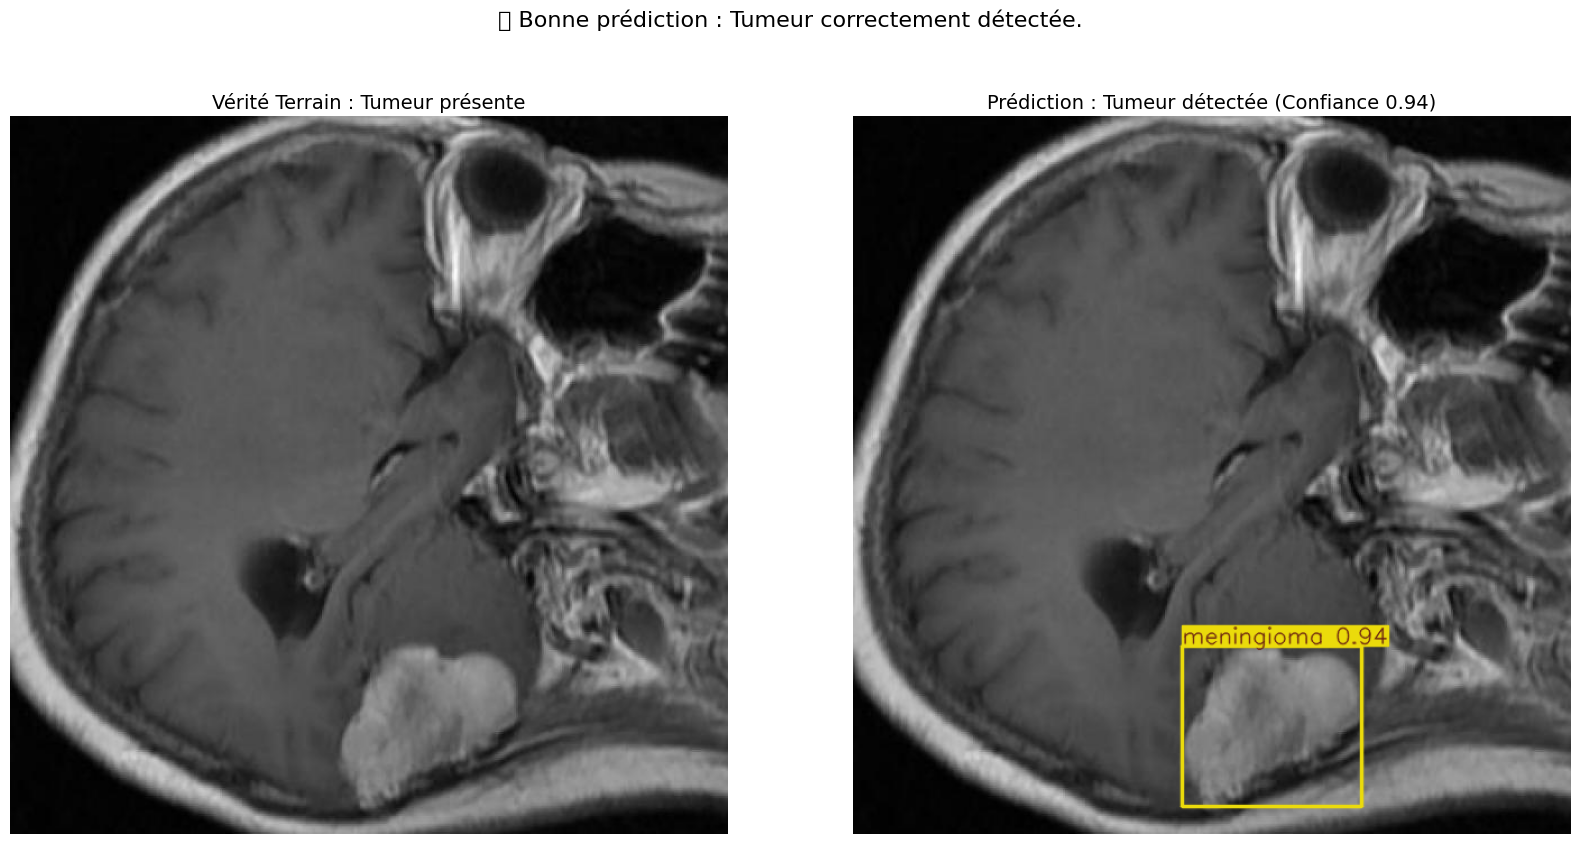

In [35]:
# ==================================
# 🧠 Visualisation Réalité vs Prédiction (Version humaine)
# ==================================

import matplotlib.pyplot as plt
import cv2
import os
import random

# Choisir une image au hasard du dossier test
test_images_path = os.path.join(dataset_path, "test", "images")
image_name = random.choice(os.listdir(test_images_path))
image_path = os.path.join(test_images_path, image_name)

# Chemin vers les labels réels
test_labels_path = os.path.join(dataset_path, "test", "labels")
label_name = image_name.replace(".jpg", ".txt").replace(".png", ".txt")
label_path = os.path.join(test_labels_path, label_name)

# Charger l'image originale
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Charger le label réel
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        real_label = f.readline().strip().split()
        class_id = int(real_label[0])
else:
    class_id = None

# Traduction label réel
if class_id is None:
    real_status = "Pas de tumeur présente"
else:
    real_status = "Tumeur présente"

# Prédiction avec YOLO
pred = model.predict(image_path, save=False, imgsz=640, conf=0.25)[0]

# Image prédite
pred_img = pred.plot()

# Classe prédite
if len(pred.boxes.cls) > 0:
    pred_class = int(pred.boxes.cls[0])
    pred_conf = float(pred.boxes.conf[0])
    pred_status = "Tumeur détectée"
else:
    pred_class = None
    pred_conf = 0
    pred_status = "Pas de tumeur détectée"

# Évaluation humaine
if real_status == "Tumeur présente" and pred_status == "Tumeur détectée":
    evaluation = "✅ Bonne prédiction : Tumeur correctement détectée."
elif real_status == "Pas de tumeur présente" and pred_status == "Pas de tumeur détectée":
    evaluation = "✅ Bonne prédiction : Absence de tumeur confirmée."
elif real_status == "Tumeur présente" and pred_status == "Pas de tumeur détectée":
    evaluation = "❌ Mauvaise prédiction : Tumeur manquée."
else:
    evaluation = "❌ Mauvaise prédiction : Faux positif, tumeur détectée à tort."

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(17, 8))

# Image gauche = vérité terrain
axes[0].imshow(img_rgb)
axes[0].set_title(f"Vérité Terrain : {real_status}", fontsize=14)
axes[0].axis("off")

# Image droite = prédiction YOLO
axes[1].imshow(pred_img)
axes[1].set_title(f"Prédiction : {pred_status} (Confiance {pred_conf:.2f})", fontsize=14)
axes[1].axis("off")

plt.suptitle(evaluation, fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


---

##  8. Comparaison visuelle : Vérité Terrain vs Prédiction

Pour mieux comprendre les résultats, nous affichons côte à côte :
- L’image IRM originale avec son annotation médicale réelle.
- L’image avec les prédictions générées par YOLOv8.

Cela permet une évaluation clinique qualitative du modèle.


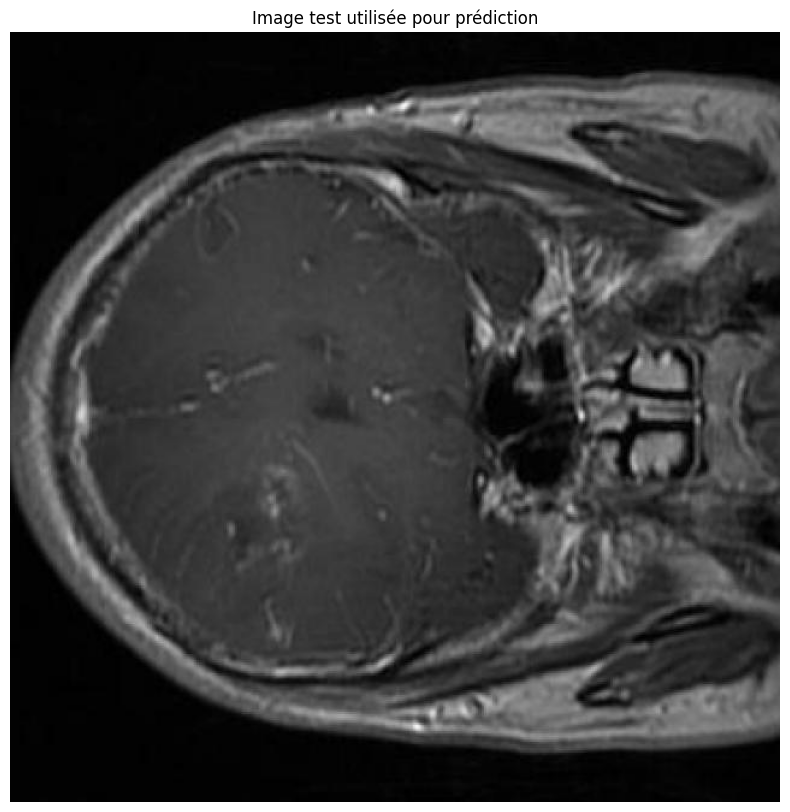

In [36]:
# ==================================
# Visualisation avec Matplotlib
# ==================================

import matplotlib.pyplot as plt
import cv2
import os
import random


dataset_path = "/content/brain_tumor_dataset/BrainTumor/BrainTumorYolov8"
test_images_path = os.path.join(dataset_path, "test", "images") # Define test_images_path here

# Choisir une image au hasard du dossier test
image_name = random.choice(os.listdir(test_images_path))
test_image_path = os.path.join(test_images_path, image_name) # Define test_image_path here

img = cv2.imread(test_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Image test utilisée pour prédiction")
plt.axis("off")
plt.show()

---

## 💾 9. Sauvegarde du meilleur modèle entraîné

Le modèle ayant obtenu les meilleures performances sur les données de validation est enregistré.  
Cela permet une réutilisation pour une mise en production, une intégration clinique ou une poursuite de l'amélioration.


In [37]:
# ========================================
# 💾 Sauvegarde du modèle entraîné (best.pt)
# ========================================

# Chemin où YOLOv8 a sauvegardé automatiquement les poids
best_model_path = "/content/brain_tumor_results/yolov8_brain_tumor/weights/best.pt"

# Vérification de l'existence
import os
assert os.path.exists(best_model_path), " Le fichier best.pt n'a pas été trouvé."

# Chargement du meilleur modèle
best_model = YOLO(best_model_path)
print(" Meilleur modèle chargé avec succès.")

# Optionnel : si tu veux copier ce modèle ailleurs
final_model_save_path = "/content/best_brain_tumor_model.pt"
os.rename(best_model_path, final_model_save_path)
print(f"Modèle final sauvegardé sous : {final_model_save_path}")


 Meilleur modèle chargé avec succès.
Modèle final sauvegardé sous : /content/best_brain_tumor_model.pt


✅ Modèle best.pt chargé avec succès.


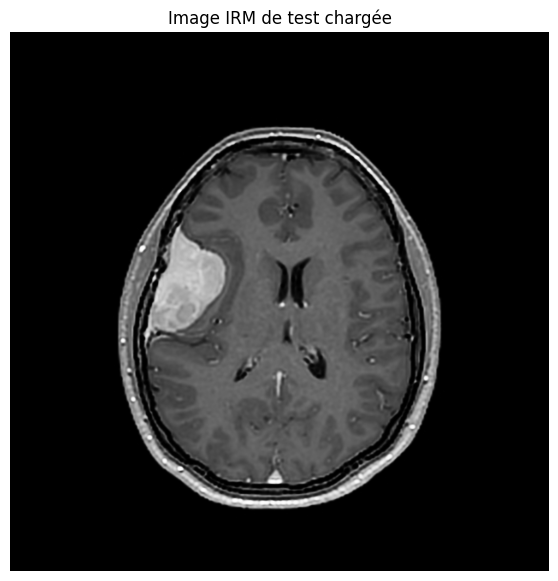


image 1/1 /content/mon_image_irm_test.jpeg: 640x640 1 meningioma, 7.7ms
Speed: 3.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

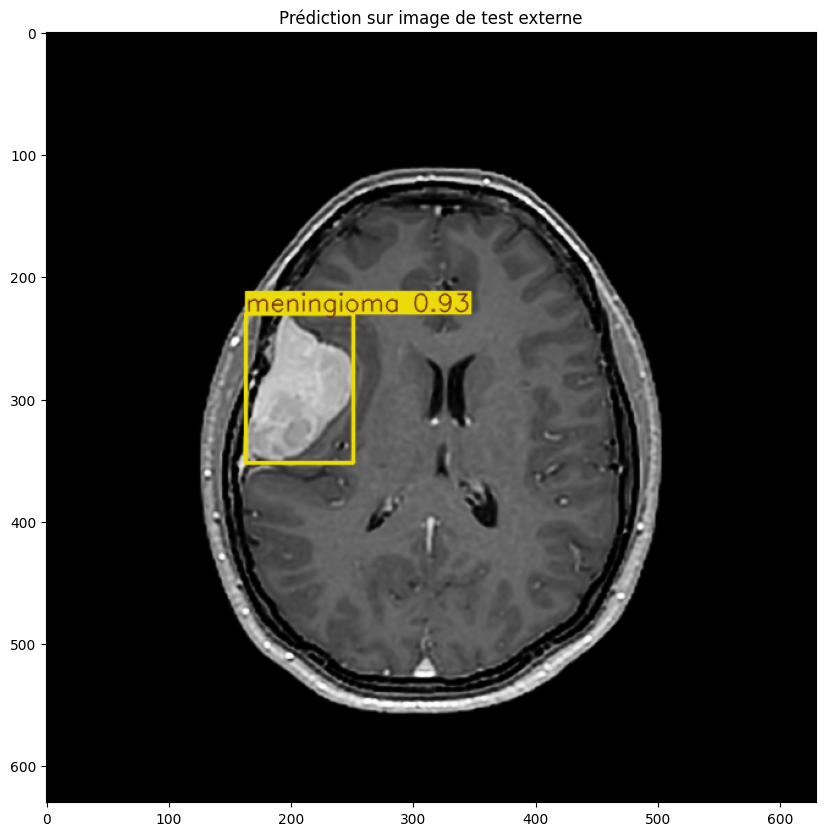

In [42]:
# =========================================
# 🧠 Test sur une image externe avec le meilleur modèle (best.pt)
# =========================================

import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# === 0. Charger le meilleur modèle sauvegardé ===
best_model_path = "/content/best_brain_tumor_model.pt"  # <-- adapte si besoin
assert Path(best_model_path).exists(), f"Erreur : Le modèle best.pt n'a pas été trouvé à {best_model_path}"

# Charger le modèle best
best_model = YOLO(best_model_path)
print("✅ Modèle best.pt chargé avec succès.")

# === 1. Charger une image externe ===
image_path = "/content/mon_image_irm_test.jpeg"  # <-- adapte ce chemin à ton image perso

# Vérification de l'existence du fichier
assert Path(image_path).exists(), f"L'image {image_path} n'existe pas."

# Lire l'image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Afficher l'image de test
plt.figure(figsize=(7,7))
plt.imshow(img_rgb)
plt.title("Image IRM de test chargée")
plt.axis("off")
plt.show()

# === 2. Faire une prédiction avec le modèle best ===
pred = best_model.predict(source=image_path, save=False, imgsz=640, conf=0.25)[0]

# Récupérer l'image prédite
pred_img = pred.plot()

# === 3. Afficher Résultat ===
plt.figure(figsize=(10,10))
plt.imshow(pred_img)
plt.title("Prédiction sur image de test externe")
plt
